# Table of Contents

- [Environment](#Environment)
- [Gathering](#Gathering)
    - [Twitter Archive](#Twitter-Archive)
    - [Additional Data from Twitter API](#Additional-Data-from-Twitter-API)
    - [Image Predictions](#Image-Predictions)
- [Assessing](#Assessing)
- [Cleaning](#Cleaning)
    - [Tidiness issues](#Tidiness-issues)
        - [Combining `archive_df` and `api_df`](#Combining-archive_df-and-api_df)
        - [Combining `master_df_clean` and `images_df`](#Combining-master_df_clean-and-images_df)
        - [Dog stage info should be in a single column](#Dog-stage-info-should-be-in-a-single-column)
    - [Quality issues](#Quality-issues)
        - [Keeping just one dog breed](#Keeping-just-one-dog-breed)
        - [Removing Retweets](#Removing-Retweets)
        - [Removing tweets with more than one dog stage](#Removing-tweets-with-more-than-one-dog-stage)
        - [Fixing ratings](#Fixing-ratings)
        - [Fixing `timestamp` and `retweeted_status_timestamp` datatype](#Fixing-timestamp-and-retweeted_status_timestamp-datatype)
        - [Removing tweets from after Aug 1st, 2017](#Removing-tweets-from-after-Aug-1st,-2017)
        - [Uppercase words and underscores in dog breed names](#Uppercase-words-and-underscores-in-dog-breed-names)
        - [Invalid dog names](#Invalid-dog-names)
        - [Removing unused columns](#Removing-unused-columns)
- [Storing](#Storing)
- [Analysis](#Analysis)
    - [Dog breeds](#Dog-breeds)
        - [Most mentioned overall](#Most-mentioned-overall)
        - [Most liked](#Most-liked)
        - [Most retweeted](#Most-retweeted)
    - [Names](#Names)
        - [Most common](#Most-common)
        - [Most common per breed](#Most-common-per-breed)
    - [Stages](#Stages)
        - [Tweets per stage](#Tweets-per-stage)
        - [Likes per stage](#Likes-per-stage)

# Environment

In [1]:
import datetime
from datetime import date
import io
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
import tweepy

In [2]:
%matplotlib inline
sns.set_context('notebook', font_scale=1.25)

# Gathering

## Twitter Archive

This first part of our dataset comes directly from Udacity assignment. We just need to import it.

In [3]:
archive_df = pd.read_csv('../data/twitter-archive-enhanced.csv')

In [4]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


## Additional Data from Twitter API

Credentials come from my personal Twitter account, written in a separate JSON file for safety reasons.

In [5]:
with open(os.path.join("../params/", "twitter-api-credentials.json"), "r") as config_file:
    configs = json.load(config_file)

In [6]:
auth = tweepy.OAuthHandler(configs['consumer_key'], configs['consumer_secret'])
auth.set_access_token(configs['access_token'], configs['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

For each tweet ID found within Udacity's archive, we call Twitter API to gather favorite and retweet counts. If we don't find the tweet for whatever reason, we save its ID within a dictionary, so we have it somewhere safe, in case we need them later.

In [7]:
failed_api_queries = {}

with open(os.path.join("../data/", "tweet_json.txt"), "w") as tweet_file:
    for tweet_id in archive_df.tweet_id.values:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, tweet_file)
            tweet_file.write("\n")
        except Exception as exc:
            failed_api_queries[tweet_id] = exc

Rate limit reached. Sleeping for: 542
Rate limit reached. Sleeping for: 529


With all the extra data gathered from the API, now we just read them into a new DataFrame.

In [8]:
with open(os.path.join("../data/", "tweet_json.txt"), "r") as file:
    file_content = file.readlines()

In [9]:
api_df_rows = []

for line in file_content:
    json_content = json.loads(line)
    api_df_rows.append([json_content.get('id'), json_content.get('retweet_count'), json_content.get('favorite_count')])

In [10]:
api_df = pd.DataFrame.from_records(data=api_df_rows, columns=['tweet_id', 'retweet_count', 'favorite_count'])

In [11]:
api_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7132,34341
1,892177421306343426,5373,29760
2,891815181378084864,3536,22408
3,891689557279858688,7333,37512
4,891327558926688256,7879,35837


## Image Predictions

Another dataset from Udacity assignment, but we need to get this one with a HTTP request.

In [12]:
images_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
images_response = requests.get(images_url)
images_response

<Response [200]>

The response comes in byte format, so we decode it and use `StringIO` to make it easier to work with response content as we would with a simple file.

In [13]:
images_df = pd.read_csv(io.StringIO(images_response.content.decode('utf-8')), sep="\t")

In [14]:
images_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


# Assessing

## Twitter Archive

### Quality
- Null values in `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `expanded_urls`.
- Some of the tweets are actually retweets and should be deleted, as per Udacity's request.
- Wrong datatype in `timestamp` and `retweeted_status_timestamp`.
- Invalid dog names (like "a", "the").
- Invalid rating numerators.
- Invalid rating denominators (they should always be 10).
- Some tweets may mention two dog stages (how would we know which one we extract data on?).
- We need to remove tweets newer than August 1st, 2017, as per another Udacity's request.
- Some columns won't be used.

### Tidiness
- Dog stages should be contained in one column, not spread across four.

In [15]:
archive_df.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [16]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [17]:
sum(archive_df.duplicated())

0

Investigating the dog names:

In [18]:
archive_df['name'].value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [19]:
for tweet_text in archive_df.query("name == 'the'")['text']:
    print(tweet_text)

Stop sending in lobsters. This is the final warning. We only rate dogs. Thank you... 9/10 https://t.co/B9ZXXKJYNx
This is the newly formed pupper a capella group. They're just starting out but I see tons of potential. 8/10 for all https://t.co/wbAcvFoNtn
This is the happiest pupper I've ever seen. 10/10 would trade lives with https://t.co/ep8ATEJwRb
This is the saddest/sweetest/best picture I've been sent. 12/10 😢🐶 https://t.co/vQ2Lw1BLBF
This is the best thing I've ever seen so spread it like wildfire &amp; maybe we'll find the genius who created it. 13/10 https://t.co/q6RsuOVYwU
Never forget this vine. You will not stop watching for at least 15 minutes. This is the second coveted.. 13/10 https://t.co/roqIxCvEB3
This is the happiest dog you will ever see. Very committed owner. Nice couch. 10/10 https://t.co/RhUEAloehK
Here is the Rand Paul of retrievers folks! He's probably good at poker. Can drink beer (lol rad). 8/10 good dog https://t.co/pYAJkAe76p


The standard rating system today (and a while ago) involves some score out of 10. Numerator can be greater than the denominator.

In [20]:
archive_df['rating_numerator'].value_counts().sort_index(ascending=True)

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

In [21]:
archive_df['rating_denominator'].value_counts().sort_index(ascending=True)

0         1
2         1
7         1
10     2333
11        3
15        1
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
Name: rating_denominator, dtype: int64

Now we check if there are tweets that mention more than one stage. If there are, we should just pick one, or none at all.

In [22]:
dog_stages = ['doggo', 'pupper', 'puppo', 'floofer']
dog_stages_found = {}

for tweet in archive_df.tweet_id:
    tweet_text = archive_df.query("tweet_id == @tweet")['text'].values[0]
    dog_stages_found[tweet] = sum(stage_count > 0 for stage_count in [tweet_text.count(stage) for stage in dog_stages])

In [23]:
more_than_1_stage = [key for key, value in dog_stages_found.items() if value > 1]

In [24]:
for tweet in archive_df.query("tweet_id in @more_than_1_stage")['text']:
    print(tweet)

I have stumbled puppon a doggo painting party. They're looking to be the next Pupcasso or Puppollock. All 13/10 would put it on the fridge https://t.co/cUeDMlHJbq
Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel
Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze
This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd
RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda
RT @dog_rates: This is just downright precious af. 12/10 for bo

Checking up on ratings with a denominator other than 10:

In [25]:
for tweet in archive_df.query("rating_denominator != 10")['text']:
    print(tweet, "\n")

@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho 

@docmisterio account started on 11/15/15 

The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd 

Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx 

RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/… 

Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE 

After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ 

Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv 

Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a 

This is Bluebert. He just 

Now checking the timespan:

In [26]:
min(archive_df['timestamp']), max(archive_df['timestamp'])

('2015-11-15 22:32:08 +0000', '2017-08-01 16:23:56 +0000')

## Additional Data from Twitter API

### Quality
- Some of the tweets were deleted since the dataset's creation, so they weren't found by the API.

### Tidiness
- This data should be part of the previous DataFrame, not a standalone dataset.

In [27]:
api_df.head(10)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7132,34341
1,892177421306343426,5373,29760
2,891815181378084864,3536,22408
3,891689557279858688,7333,37512
4,891327558926688256,7879,35837
5,891087950875897856,2650,18094
6,890971913173991426,1700,10536
7,890729181411237888,16040,57730
8,890609185150312448,3677,24908
9,890240255349198849,6192,28399


In [28]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2328 non-null   int64
 1   retweet_count   2328 non-null   int64
 2   favorite_count  2328 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [29]:
sum(api_df.duplicated())

0

In [30]:
api_df.describe()

,tweet_id,retweet_count,favorite_count
count,2.328000e+03,2328.000000,2328.000000
mean,7.418403e+17,2513.009021,7161.935997
std,6.823143e+16,4256.234101,11127.659651
min,6.660209e+17,1.000000,0.000000
25%,6.781974e+17,505.750000,1243.750000
50%,7.180382e+17,1169.000000,3094.500000
75%,7.986673e+17,2911.250000,8740.750000
max,8.924206e+17,72041.000000,147044.000000


## Image Predictions

### Quality
- Some breed names starting with uppercase.
- Breed names with words separated by underscores, instead of whitespaces.
- Non-descriptive column names.
- Dog breed could be in one of three different columns.

### Tidiness
- These data should also be part of a main DataFrame.
- Since we want just the dog breed, most of the columns won't be used here.


In [31]:
images_df.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [32]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [33]:
sum(images_df.duplicated())

0

In [34]:
images_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [35]:
images_df['tweet_id'].nunique()

2075

In [36]:
np.sort(images_df.query('p1_dog')['p1'].unique())

array(['Afghan_hound', 'Airedale', 'American_Staffordshire_terrier',
       'Appenzeller', 'Australian_terrier', 'Bedlington_terrier',
       'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie',
       'Border_terrier', 'Boston_bull', 'Brabancon_griffon',
       'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever',
       'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_setter',
       'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog',
       'German_shepherd', 'German_short-haired_pointer', 'Gordon_setter',
       'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog',
       'Ibizan_hound', 'Irish_setter', 'Irish_terrier',
       'Irish_water_spaniel', 'Italian_greyhound', 'Japanese_spaniel',
       'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa',
       'Maltese_dog', 'Mexican_hairless', 'Newfoundland',
       'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier',
       'Old_English_sheepdog', 'Pekinese', 'Pembroke', 'Pomera

# Cleaning

In [90]:
archive_df_clean = archive_df.copy()
api_df_clean = api_df.copy()
images_df_clean = images_df.copy()

## Tidiness issues

### Combining `archive_df` and `api_df`

#### Define

We'll combine `archive_df` and `api_df` into a single DataFrame, joining them by `tweet_id` column.

By joining these datasets using "inner join", we get just the tweets contained in both of them, automatically solving the missing tweet data issue.

#### Code

In [91]:
master_df_clean = archive_df_clean.join(api_df_clean.set_index('tweet_id'), on='tweet_id', how='inner')

#### Test

In [92]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2328 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2328 non-null   object 
 4   source                      2328 non-null   object 
 5   text                        2328 non-null   object 
 6   retweeted_status_id         161 non-null    float64
 7   retweeted_status_user_id    161 non-null    float64
 8   retweeted_status_timestamp  161 non-null    object 
 9   expanded_urls               2270 non-null   object 
 10  rating_numerator            2328 non-null   int64  
 11  rating_denominator          2328 non-null   int64  
 12  name                        2328 non-null   object 
 13  doggo                       2328 

In [93]:
master_df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,7132,34341
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,5373,29760
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,3536,22408
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,7333,37512
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,7879,35837


### Combining `master_df_clean` and `images_df`

#### Define

We'll join both DataFrames just as we've done above.

#### Code

In [94]:
master_df_clean = master_df_clean.join(images_df_clean.set_index('tweet_id'), on='tweet_id', how='inner').reset_index(drop=True)

#### Test

In [95]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058 entries, 0 to 2057
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2058 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2058 non-null   object 
 4   source                      2058 non-null   object 
 5   text                        2058 non-null   object 
 6   retweeted_status_id         72 non-null     float64
 7   retweeted_status_user_id    72 non-null     float64
 8   retweeted_status_timestamp  72 non-null     object 
 9   expanded_urls               2058 non-null   object 
 10  rating_numerator            2058 non-null   int64  
 11  rating_denominator          2058 non-null   int64  
 12  name                        2058 non-null   object 
 13  doggo                       2058 

In [96]:
master_df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


### Dog stage info should be in a single column

#### Define

We need to use a regular expression to extract the correct stage and create a new, unified column for the stages.

For now, if there's more than one stage in a column, only the first one will be considered. We're taking a closer look on these cases later.

#### Code

In [97]:
master_df_clean['stage'] = master_df_clean['text'].str.extract(r'(doggo|pupper|puppo|floofer)')
master_df_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

#### Test

In [98]:
master_df_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,NaN


In [99]:
master_df_clean['stage'].value_counts()

pupper     230
doggo       73
puppo       28
floofer      3
Name: stage, dtype: int64

## Quality issues

### Keeping just one dog breed

#### Define
Get the first confirmed dog breed along the three predictions.

#### Code

Given the fact the columns `pred_1_is_a_dog`, `pred_2_is_a_dog` and `pred_3_is_a_dog` are Boolean, and Boolean variables can be added, we calculate the sum of "dog predictions" per tweet, and then find the first position where this count changes from 0 to 1 (meaning it's the first prediction that gave us a breed).

We get first one, because there's an ordinal relationship between these predictions (i.e. the first prediction is always the one with the highest confidence score).

In [100]:
breed_confirmations = master_df_clean[['p1_dog', 'p2_dog', 'p3_dog']]
first_confirmation = (breed_confirmations.cumsum(axis=1) == 1).idxmax(axis=1)
first_confirmation.head()

0    p1_dog
1    p1_dog
2    p1_dog
3    p2_dog
4    p1_dog
dtype: object

Then we get the column index where the first identified breed is.

In [101]:
first_confirmed_breed = [master_df_clean.columns.get_loc(item) - 2 for item in first_confirmation] # considering we have pred_1, then pred_1_confidence, then pred_1 is a dog
first_confirmed_breed[:5]

[17, 17, 17, 20, 17]

Now we finish the feature engineering process by creating a new column with the breed name.

In [102]:
master_df_clean['breed'] = pd.Series([master_df_clean.iat[tweet, breed] for tweet, breed in zip(master_df_clean.index, first_confirmed_breed)])

And we delete the prediction columns, since we already have the information we ultimately wanted.

In [103]:
master_df_clean.drop(columns=[
    'p1', 
    'p1_conf', 
    'p1_dog', 
    'p2', 
    'p2_conf', 
    'p2_dog',
    'p3', 
    'p3_conf', 
    'p3_dog'
], inplace=True)

#### Test

In [104]:
master_df_clean['breed'].head()

0                orange
1             Chihuahua
2             Chihuahua
3    Labrador_retriever
4                basset
Name: breed, dtype: object

### Removing Retweets

#### Define
Drop rows whose `retweeted_status_id` value is not null, as requested by Udacity.

#### Code

In [105]:
master_df_clean = master_df_clean[pd.isnull(master_df_clean['retweeted_status_id'])].reset_index(drop=True)

#### Test

In [106]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1986 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   1986 non-null   object 
 4   source                      1986 non-null   object 
 5   text                        1986 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1986 non-null   object 
 10  rating_numerator            1986 non-null   int64  
 11  rating_denominator          1986 non-null   int64  
 12  name                        1986 non-null   object 
 13  retweet_count               1986 

### Removing tweets with more than one dog stage

#### Define
First, we count how many dog stages (from a previously defined list) are there in the tweet content.

After that, every tweet whose stage count is more than one will be dropped from the DataFrame.

#### Code

In [107]:
dog_stages = ['doggo', 'pupper', 'puppo', 'floofer']
dog_stages_found = {}

for tt_id in master_df_clean.tweet_id:
    tweet_text = master_df_clean.query("tweet_id == @tt_id")['text'].values[0]
    dog_stages_found[tt_id] = sum(stage_count > 0 for stage_count in [tweet_text.count(stage) for stage in dog_stages])

In [108]:
invalid_dog_stage_tweets = [key for key, value in dog_stages_found.items() if value > 1]
len(invalid_dog_stage_tweets)

10

In [109]:
master_df_clean = master_df_clean[~master_df_clean['tweet_id'].isin(invalid_dog_stage_tweets)]

#### Test

In [110]:
dog_stages_test = {}

for tweet in master_df_clean.tweet_id:
    tweet_text = master_df_clean.query("tweet_id == @tweet")['text'].values[0]
    dog_stages_test[tweet] = sum(stage_count > 0 for stage_count in [tweet_text.count(stage) for stage in dog_stages])

In [111]:
print(len([key for key, value in dog_stages_test.items() if value > 1]))

0


### Fixing ratings

#### Define

Find tweets whose rating follows the "XX/10" pattern. Split this substring into two numerals, and then update `rating_numerator` and `rating_denominator`.

If the tweet doesn't conform to this pattern, it'll be dropped.

#### Code

In [112]:
for tt_id, tweet_text in zip(master_df_clean.tweet_id, master_df_clean.text):
    rating_found = re.search(r'[0-9]+\.*[0-9]*\/10', tweet_text)
    if rating_found is not None:
        correct_num, correct_den = rating_found.group().split('/')
        tweet_index = master_df_clean.index[master_df_clean['tweet_id'] == tt_id]
        master_df_clean.at[tweet_index, 'rating_numerator'] = correct_num
        master_df_clean.at[tweet_index, 'rating_denominator'] = correct_den
    else:
        master_df_clean = master_df_clean[master_df_clean['tweet_id'] != tt_id].copy()

#### Test

In [113]:
master_df_clean.rating_numerator.value_counts()

12       443
10       417
11       396
13       256
9        151
8         95
7         51
14        36
6         32
5         31
3         19
4         15
2          9
1          4
0          2
11.26      1
11.27      1
1776       1
9.75       1
13.5       1
420        1
Name: rating_numerator, dtype: int64

In [114]:
master_df_clean.rating_denominator.value_counts()

10    1963
Name: rating_denominator, dtype: int64

### Fixing `timestamp` and `retweeted_status_timestamp` datatype

#### Define
Convert these columns from **object** to **datetime64**.

#### Code

In [115]:
master_df_clean['timestamp'] = pd.to_datetime(master_df_clean['timestamp'], format="%Y-%m-%d")
master_df_clean['retweeted_status_timestamp'] = pd.to_datetime(master_df_clean['retweeted_status_timestamp'], format="%Y-%m-%d")

#### Test

In [116]:
master_df_clean['timestamp'].dtypes

datetime64[ns, UTC]

In [117]:
master_df_clean['retweeted_status_timestamp'].dtypes

dtype('<M8[ns]')

### Removing tweets from after Aug 1st, 2017

#### Define
Filter out rows whose `timestamp` is newer than this date.

#### Code

In [118]:
master_df_clean = master_df_clean[master_df_clean['timestamp'].dt.date < datetime.date(2017, 8, 1)].reset_index(drop=True)

#### Test

In [119]:
min(master_df_clean['timestamp'])

Timestamp('2015-11-15 22:32:08+0000', tz='UTC')

In [120]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 0 to 1960
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1961 non-null   int64              
 1   in_reply_to_status_id       21 non-null     float64            
 2   in_reply_to_user_id         21 non-null     float64            
 3   timestamp                   1961 non-null   datetime64[ns, UTC]
 4   source                      1961 non-null   object             
 5   text                        1961 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      datetime64[ns]     
 9   expanded_urls               1961 non-null   object             
 10  rating_numerator            1961 non-null   object          

### Uppercase words and underscores in dog breed names

#### Define
Convert columns `pred_1`, `pred_2` and `pred_3` into lowercase, and remove underscores.

#### Code

In [121]:
master_df_clean['breed'] = master_df_clean['breed'].str.replace("_", " ").str.lower()

#### Test

In [122]:
np.sort(master_df_clean['breed'].unique())

array(['afghan hound', 'african crocodile', 'african grey', 'agama',
       'airedale', 'alp', 'american black bear',
       'american staffordshire terrier', 'angora', 'appenzeller',
       'arabian camel', 'arctic fox', 'australian terrier', 'axolotl',
       'bakery', 'bald eagle', 'balloon', 'banana', 'bannister',
       'barbell', 'barrow', 'basenji', 'basset', 'bath towel', 'bathtub',
       'beach wagon', 'beagle', 'bearskin', 'beaver',
       'bedlington terrier', 'bee eater', 'bernese mountain dog', 'bib',
       'binoculars', 'birdhouse', 'bison', 'black-and-tan coonhound',
       'black-footed ferret', 'blenheim spaniel', 'bloodhound',
       'bluetick', 'boathouse', 'bookcase', 'border collie',
       'border terrier', 'borzoi', 'boston bull', 'bouvier des flandres',
       'bow', 'bow tie', 'box turtle', 'boxer', 'brabancon griffon',
       'briard', 'brittany spaniel', 'brown bear', 'bubble',
       'bull mastiff', 'bustard', 'cairn', 'candle', 'car mirror',
       'cardi

### Invalid dog names

#### Define

Names start with capital letter. Let's keep only the rows whose `name` value follows this pattern.

#### Code

In [124]:
master_df_clean['name'] = master_df_clean['name'].apply(lambda n: np.nan if n.islower() else n)

#### Test

In [125]:
master_df_clean['name'].value_counts()

None          529
Oliver         10
Cooper         10
Charlie        10
Tucker          9
             ... 
Bookstore       1
Shiloh          1
Gustav          1
Arlen           1
Christoper      1
Name: name, Length: 909, dtype: int64

### Removing unused columns

#### Define

We're focusing our analyses on likes, retweets, breeds, and so on. So we select other columns and drop them from our DataFrame to get cleaner, pristine, straight-to-the-point data.

#### Code

In [126]:
master_df_clean.drop(columns=[
    'in_reply_to_status_id',
    'in_reply_to_user_id',
    'source',
    'retweeted_status_id',
    'retweeted_status_user_id',
    'retweeted_status_timestamp',
    'expanded_urls',
    'jpg_url',
    'img_num'
], inplace=True)

#### Test

In [127]:
master_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 0 to 1960
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1961 non-null   int64              
 1   timestamp           1961 non-null   datetime64[ns, UTC]
 2   text                1961 non-null   object             
 3   rating_numerator    1961 non-null   object             
 4   rating_denominator  1961 non-null   object             
 5   name                1866 non-null   object             
 6   retweet_count       1961 non-null   int64              
 7   favorite_count      1961 non-null   int64              
 8   stage               307 non-null    object             
 9   breed               1961 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3), object(6)
memory usage: 153.3+ KB


# Storing

In [130]:
master_df_clean.to_csv('../data/twitter_archive_master.csv', index=False, encoding='utf-8')

# Analysis

### Dog breeds

In [131]:
breed_data = master_df_clean.groupby('breed').agg({'tweet_id': 'count', 'favorite_count': sum, 'retweet_count': sum}).reset_index().rename(columns={'tweet_id': 'tweet_count'})

#### Most mentioned overall

In [132]:
top_breed_mentions = breed_data.sort_values(by='tweet_count', ascending=False).head(10)
top_breed_mentions

,breed,tweet_count,favorite_count,retweet_count
116,golden retriever,150,1618168,457585
154,labrador retriever,101,1039176,313088
209,pembroke,95,920115,240930
66,chihuahua,90,650547,209381
222,pug,62,330669,96117
288,toy poodle,50,280276,91190
69,chow,47,392929,108113
216,pomeranian,42,280433,93243
236,samoyed,41,489468,158561
173,malamute,33,309612,89988


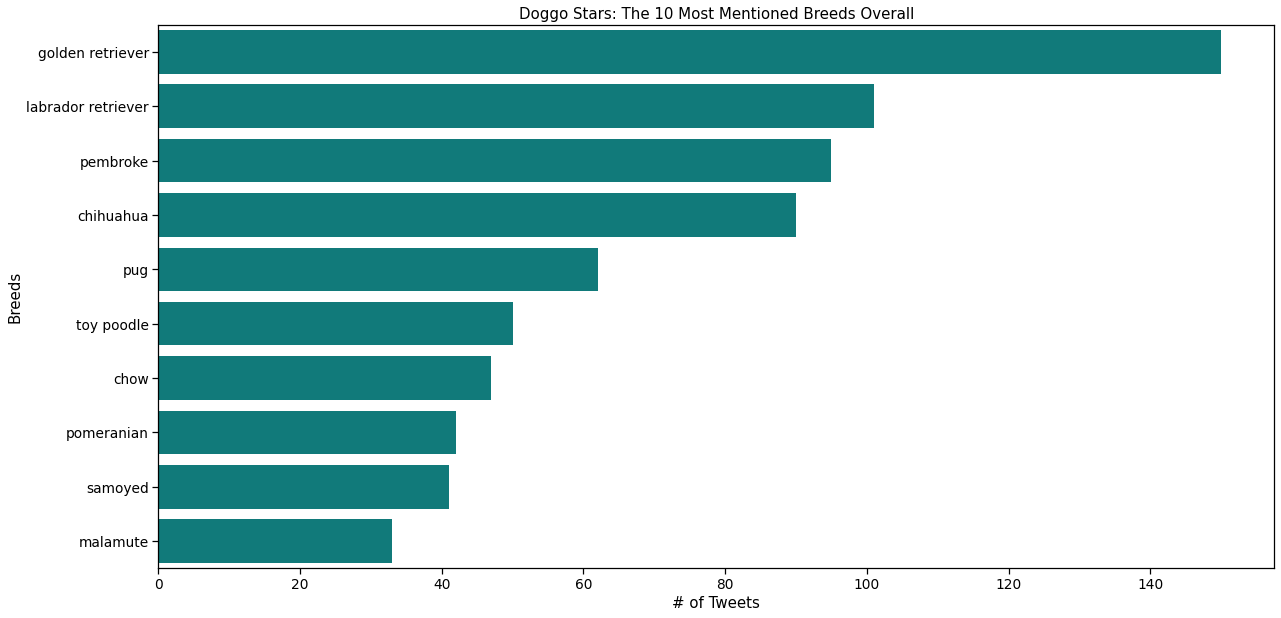

In [81]:
plt.figure(figsize=(20, 10))
plt.title("Doggo Stars: The 10 Most Mentioned Breeds Overall")
ax = sns.barplot(data=top_breed_mentions, x='tweet_count', y='breed', color='darkcyan')
ax.set_xlabel("# of Tweets")
ax.set_ylabel("Breeds")
plt.show()

#### Most liked

In [133]:
most_liked_breeds = breed_data.sort_values(by='favorite_count', ascending=False).head(10)
most_liked_breeds

,breed,tweet_count,favorite_count,retweet_count
116,golden retriever,150,1618168,457585
154,labrador retriever,101,1039176,313088
209,pembroke,95,920115,240930
66,chihuahua,90,650547,209381
109,french bulldog,30,534286,134459
236,samoyed,41,489468,158561
69,chow,47,392929,108113
74,cocker spaniel,30,357911,120808
222,pug,62,330669,96117
173,malamute,33,309612,89988


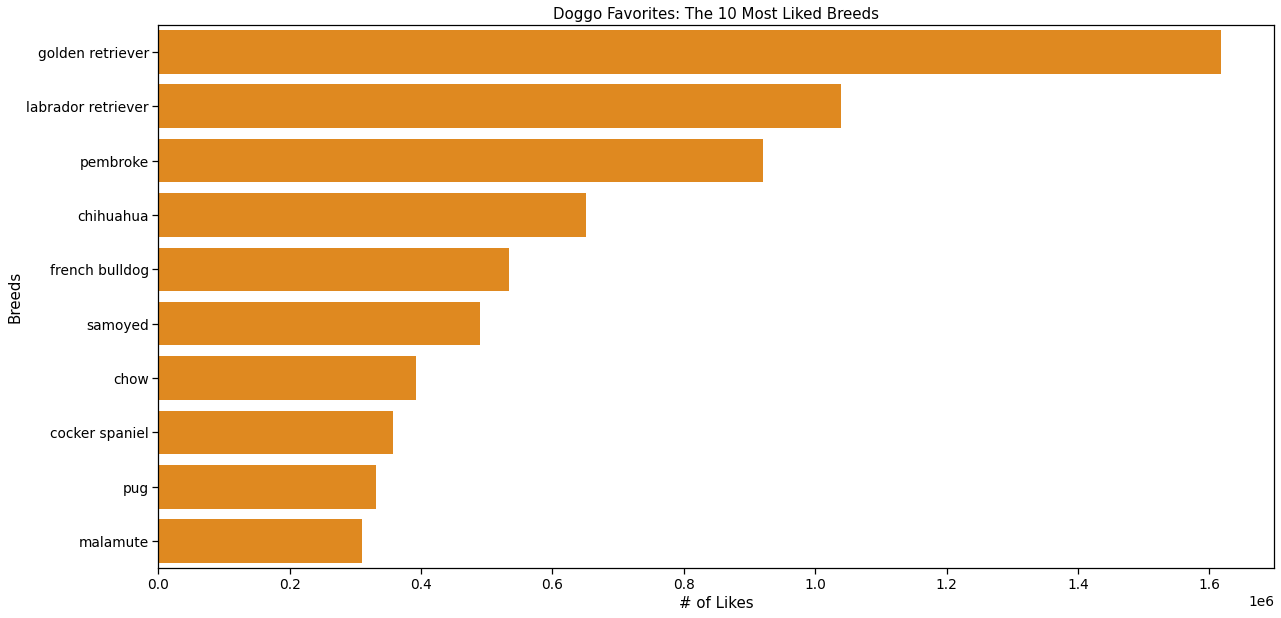

In [83]:
plt.figure(figsize=(20, 10))
plt.title("Doggo Favorites: The 10 Most Liked Breeds")
ax = sns.barplot(data=most_liked_breeds, x='favorite_count', y='breed', color='darkorange')
ax.set_xlabel("# of Likes")
ax.set_ylabel("Breeds")
plt.show()

#### Most retweeted

In [134]:
most_retweeted_breeds = breed_data.sort_values(by='retweet_count', ascending=False).head(10)
most_retweeted_breeds

,breed,tweet_count,favorite_count,retweet_count
116,golden retriever,150,1618168,457585
154,labrador retriever,101,1039176,313088
209,pembroke,95,920115,240930
66,chihuahua,90,650547,209381
236,samoyed,41,489468,158561
109,french bulldog,30,534286,134459
74,cocker spaniel,30,357911,120808
69,chow,47,392929,108113
222,pug,62,330669,96117
216,pomeranian,42,280433,93243


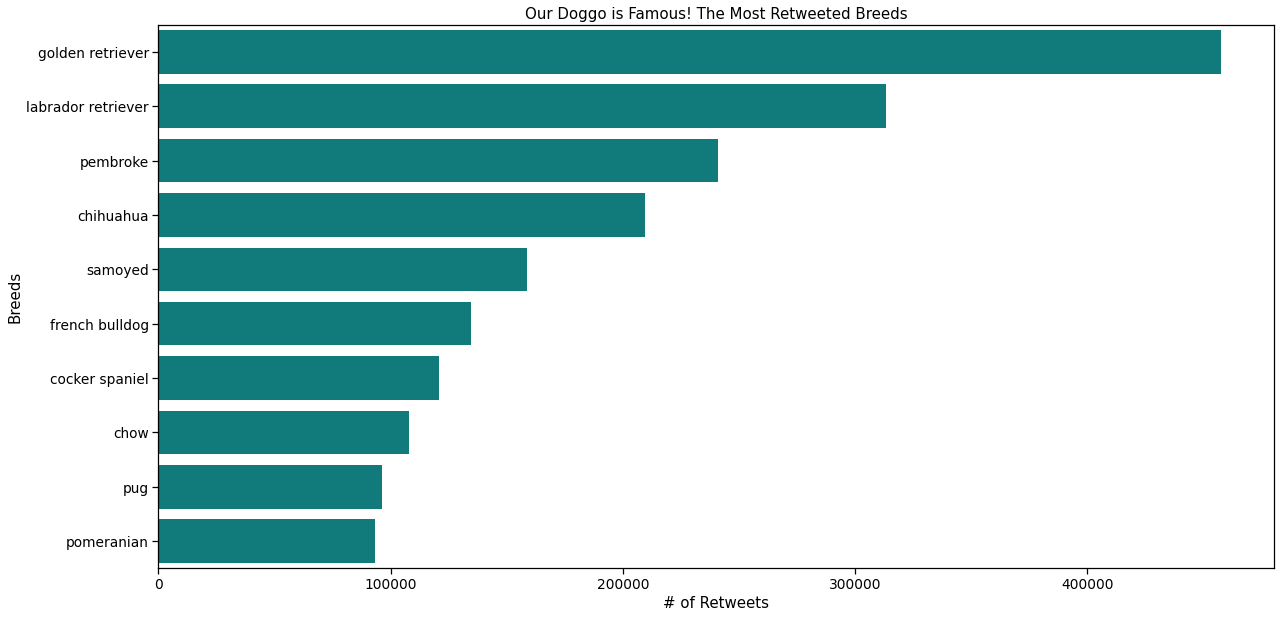

In [85]:
plt.figure(figsize=(20, 10))
plt.title("Our Doggo is Famous! The Most Retweeted Breeds")
ax = sns.barplot(data=most_retweeted_breeds, x='retweet_count', y='breed', color='darkcyan')
ax.set_xlabel("# of Retweets")
ax.set_ylabel("Breeds")
plt.show()

### Names

In [135]:
name_data = master_df_clean[pd.notnull(master_df_clean['name'])][['name', 'breed']]

#### Most common

In [136]:
top_names = name_data.groupby('name').count().rename(columns={'breed': 'name_count'})
top_names = top_names.reset_index().sort_values(by='name_count', ascending=False).head(10)
top_names

,name,name_count
622,Oliver,10
163,Charlie,10
201,Cooper,10
862,Tucker,9
531,Lucy,9
647,Penny,9
894,Winston,8
731,Sadie,8
519,Lola,7
218,Daisy,7


#### Most common per breed

In [137]:
top_breeds = top_breed_mentions['breed']

In [138]:
top_names_per_breed = name_data.query("breed in @top_breeds").groupby('breed').agg(lambda x: x.value_counts().index[0])
top_names_per_breed

,name
breed,
chihuahua,Penny
chow,Lola
golden retriever,Lucy
labrador retriever,Sadie
malamute,Odin
pembroke,Cassie
pomeranian,Emanuel
pug,Opal
samoyed,Atlas


### Stages

In [140]:
stage_data = master_df_clean[pd.notnull(master_df_clean['stage'])].groupby('stage').agg({'tweet_id': 'count', 'favorite_count': sum})
stage_data = stage_data.reset_index().rename(columns={'tweet_id': 'tweet_count'})

#### Tweets per stage

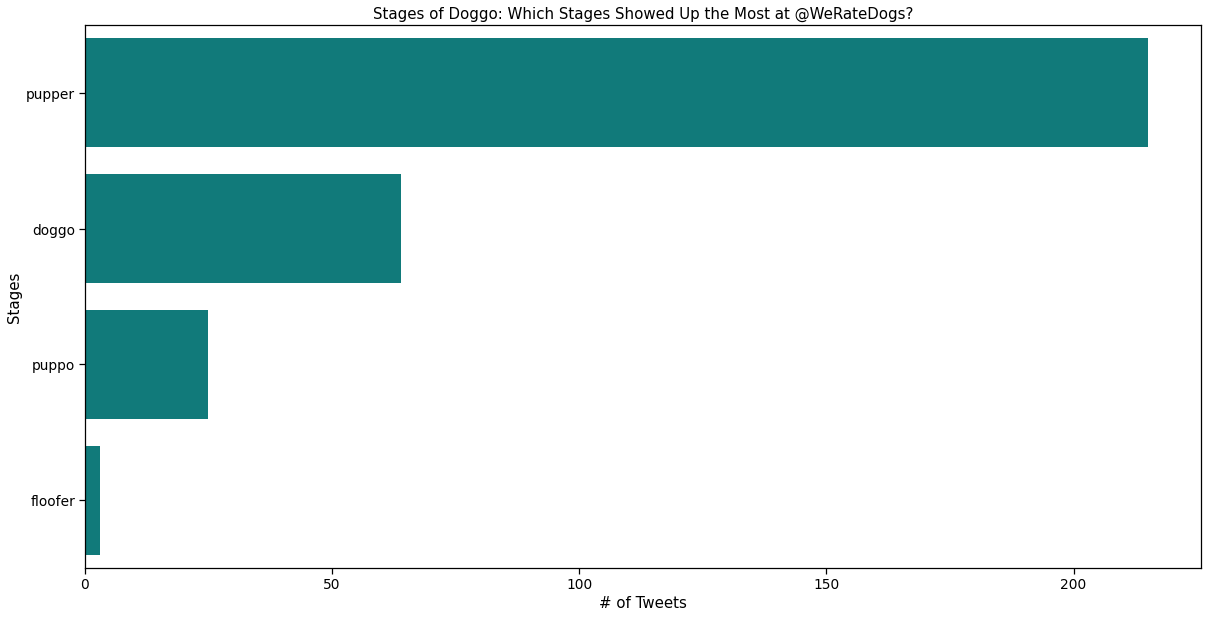

In [141]:
plt.figure(figsize=(20, 10))
plt.title("Stages of Doggo: Which Stages Showed Up the Most at @WeRateDogs?")
ax = sns.barplot(data=stage_data.sort_values(by='tweet_count', ascending=False), x='tweet_count', y='stage', color='darkcyan')
ax.set_xlabel("# of Tweets")
ax.set_ylabel("Stages")
plt.show()

#### Likes per stage

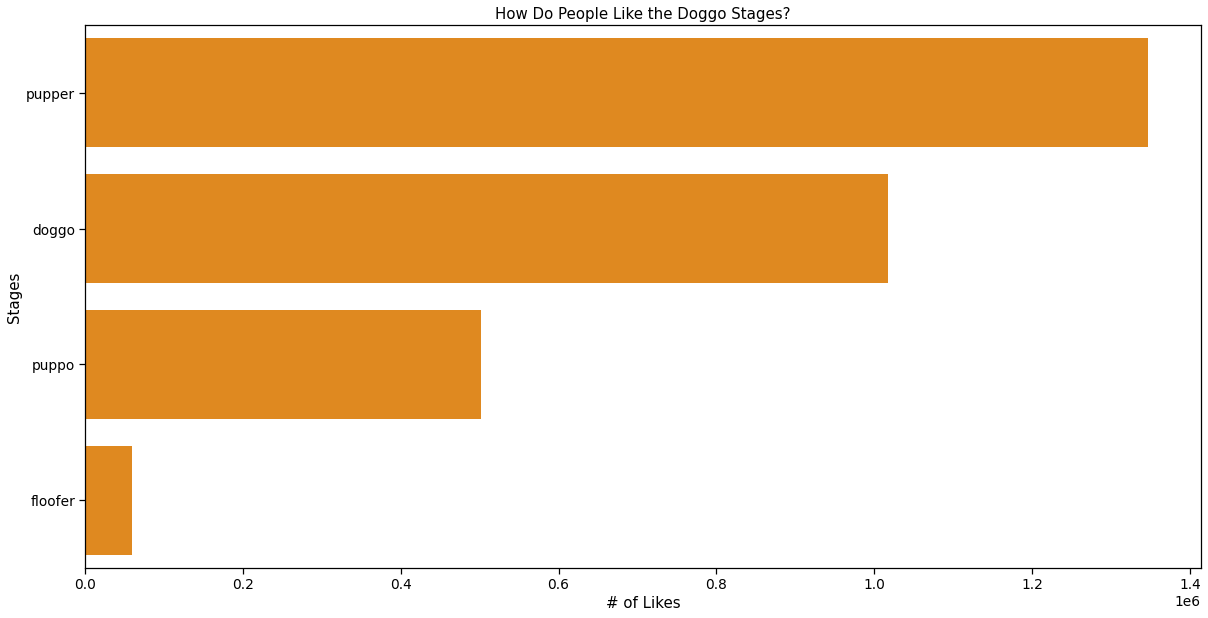

In [142]:
plt.figure(figsize=(20, 10))
plt.title("How Do People Like the Doggo Stages?")
ax = sns.barplot(data=stage_data.sort_values(by='favorite_count', ascending=False), x='favorite_count', y='stage', color='darkorange')
ax.set_xlabel("# of Likes")
ax.set_ylabel("Stages")
plt.show()